In [19]:
!pip install tensorflow[and-cuda]

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import cv2
import random
import imgaug.augmenters as iaa
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers, optimizers
# Suppress warnings
warnings.filterwarnings("ignore")

In [20]:
from keras.models import load_model

SIZE=64
# Define the known classes
classes = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on the known classes
le.fit(classes)
label_to_dx_mapping = {label: dx for label, dx in zip(le.transform(le.classes_), le.classes_)}
# Load the model
model = load_model('/kaggle/input/efficientnet/keras/efficientnet/1/efficientnet.h5')

Number of pictures for each class in test folder
dx
nv         6705
mel        1113
bkl        1099
bcc         514
akiec       327
unknown     257
Name: count, dtype: int64
label
4    6705
3    1113
2    1099
1     514
0     327
6     257
Name: count, dtype: int64
  4/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step    

I0000 00:00:1714623947.657008     176 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step


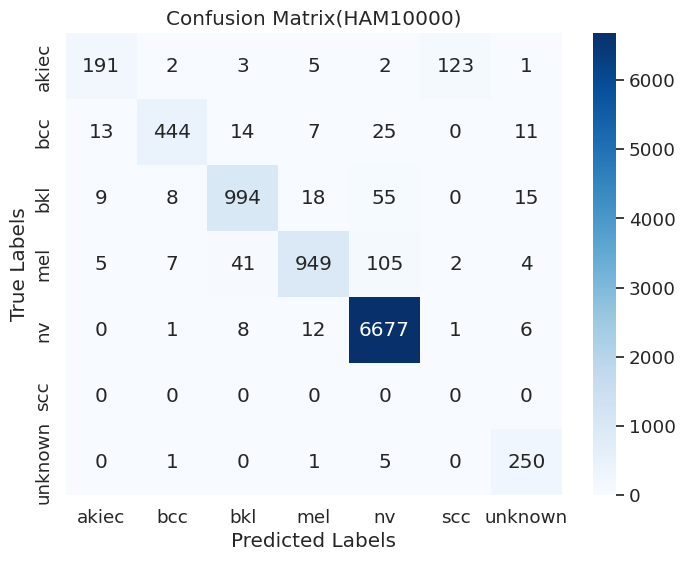


Multiclass Accuracy(HAM10000): 0.9490763854218672
HAM10000 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.876147  0.584098  0.700917    327.000000
bcc            0.958963  0.863813  0.908905    514.000000
bkl            0.937736  0.904459  0.920797   1099.000000
mel            0.956653  0.852650  0.901663   1113.000000
nv             0.972048  0.995824  0.983793   6705.000000
scc            0.000000  0.000000  0.000000      0.000000
unknown        0.871080  0.972763  0.919118    257.000000
accuracy       0.949076  0.949076  0.949076      0.949076
macro avg      0.796090  0.739087  0.762170  10015.000000
weighted avg   0.960178  0.949076  0.953013  10015.000000

Multiclass ROC AUC Score(HAM10000): 0.9245657913744464


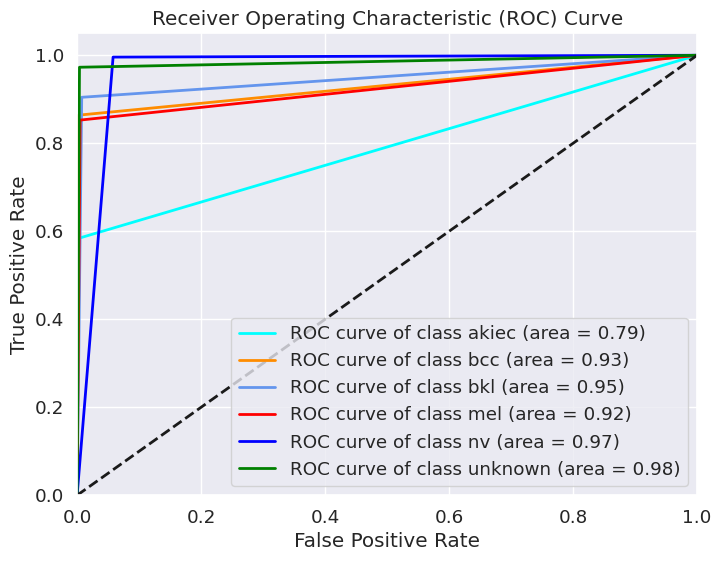

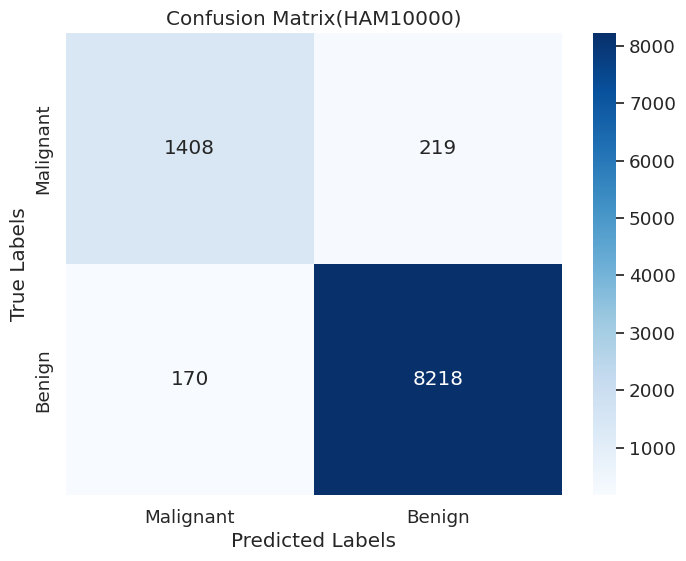


Binary Class Accuracy(HAM10000): 0.9611582626060908
HAM10000 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.892269  0.865396  0.878627   1627.000000
Benign         0.974043  0.979733  0.976880   8388.000000
accuracy       0.961158  0.961158  0.961158      0.961158
macro avg      0.933156  0.922565  0.927753  10015.000000
weighted avg   0.960758  0.961158  0.960918  10015.000000

Binary Class ROC AUC Score(HAM10000): 0.9225646934963431


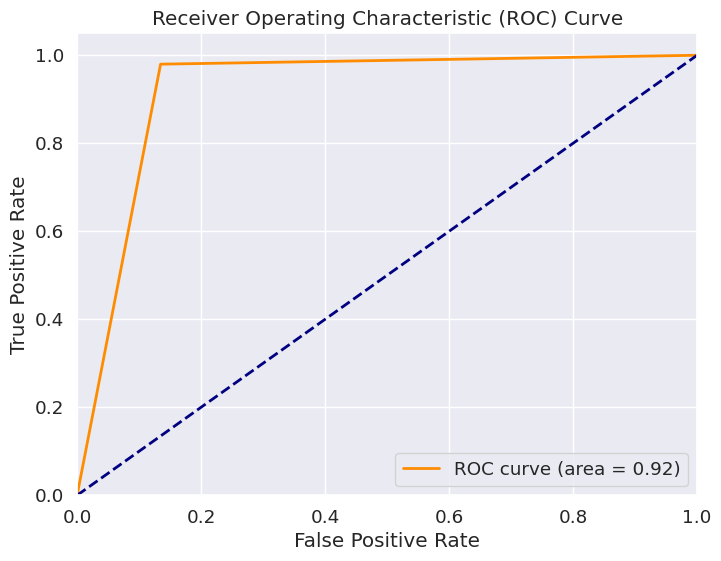

In [21]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/HAM10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    27124
nv          5193
mel          584
bkl          225
Name: count, dtype: int64
label
6    27124
4     5193
3      584
2      225
Name: count, dtype: int64
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step


W0000 00:00:1714624290.783253     176 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


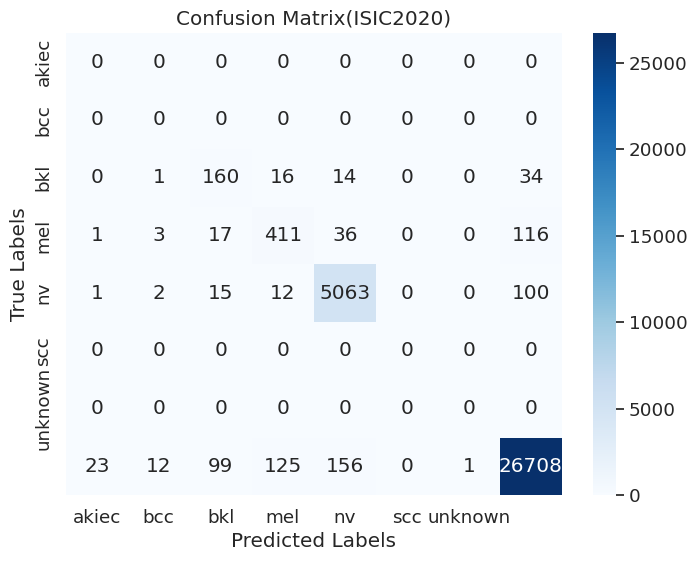


Multiclass Accuracy(ISIC2020): 0.9763327899535108
ISIC2020 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.000000  0.000000  0.000000      0.000000
bcc            0.000000  0.000000  0.000000      0.000000
bkl            0.549828  0.711111  0.620155    225.000000
mel            0.728723  0.703767  0.716028    584.000000
nv             0.960903  0.974966  0.967884   5193.000000
scc            0.000000  0.000000  0.000000      0.000000
unknown        0.990726  0.984663  0.987685  27124.000000
accuracy       0.976333  0.976333  0.976333      0.976333
macro avg      0.461454  0.482073  0.470250  33126.000000
weighted avg   0.978437  0.976333  0.977296  33126.000000

Multiclass ROC AUC Score(ISIC2020): 0.9145995917363549


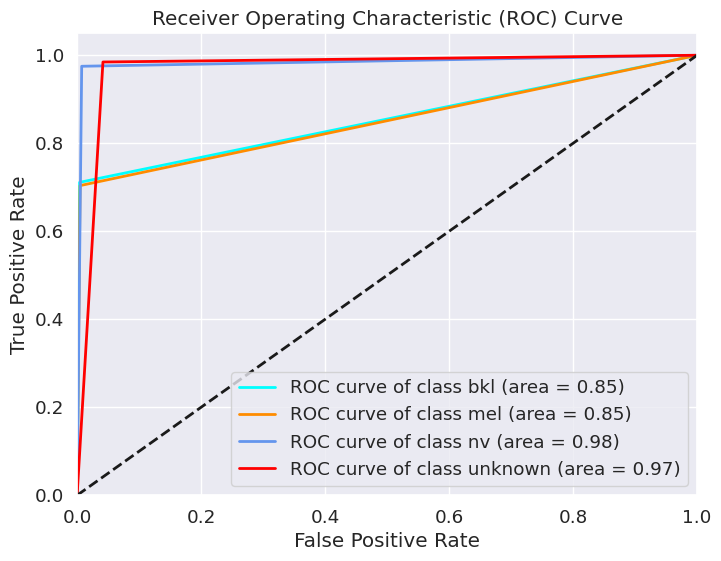

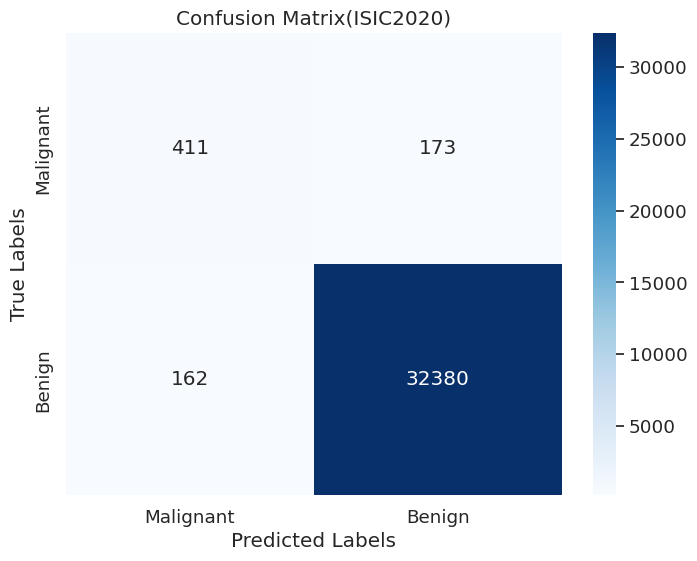


Binary Class Accuracy(ISIC2020): 0.9898870977479926
ISIC2020 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.717277  0.703767  0.710458    584.000000
Benign         0.994686  0.995022  0.994854  32542.000000
accuracy       0.989887  0.989887  0.989887      0.989887
macro avg      0.855982  0.849394  0.852656  33126.000000
weighted avg   0.989795  0.989887  0.989840  33126.000000

Binary Class ROC AUC Score(ISIC2020): 0.849394470623001


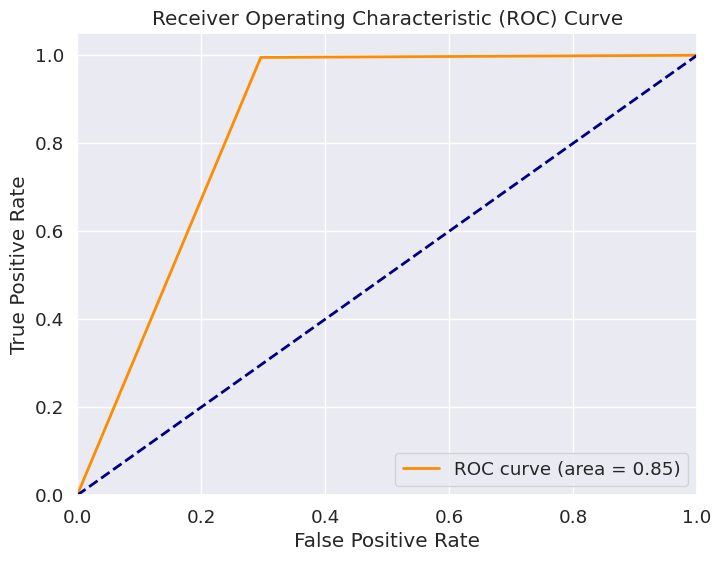

In [22]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# The row you want to insert should have the same number of elements as there are columns in conf_matrix
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         12875
mel         4522
bcc         3323
bkl         2624
akiec        867
scc          628
unknown      492
Name: count, dtype: int64
label
4    12875
3     4522
1     3323
2     2624
0      867
5      628
6      492
Name: count, dtype: int64
792/792 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step


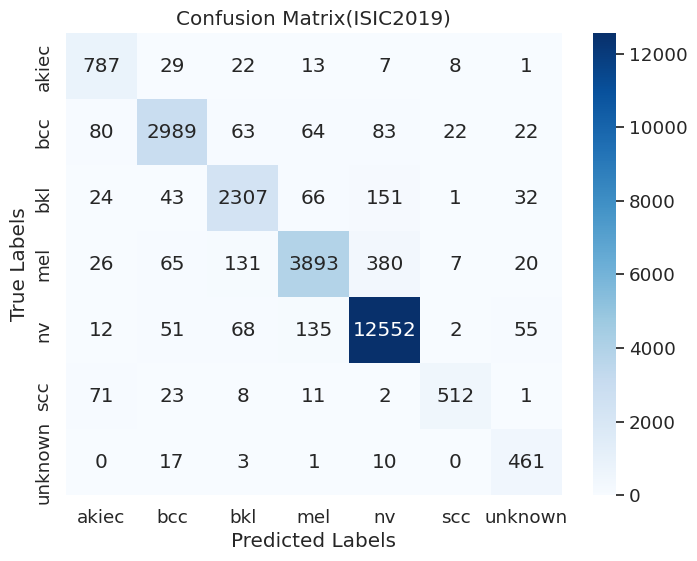


Multiclass Accuracy(ISIC2019): 0.927756503888516
ISIC2019 Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.787000  0.907728  0.843064    867.000000
bcc            0.929127  0.899488  0.914067   3323.000000
bkl            0.886626  0.879192  0.882893   2624.000000
mel            0.930672  0.860902  0.894428   4522.000000
nv             0.951991  0.974913  0.963315  12875.000000
scc            0.927536  0.815287  0.867797    628.000000
unknown        0.778716  0.936992  0.850554    492.000000
accuracy       0.927757  0.927757  0.927757      0.927757
macro avg      0.884524  0.896357  0.888017  25331.000000
weighted avg   0.928796  0.927757  0.927553  25331.000000

Multiclass ROC AUC Score(ISIC2019): 0.9407710832725277


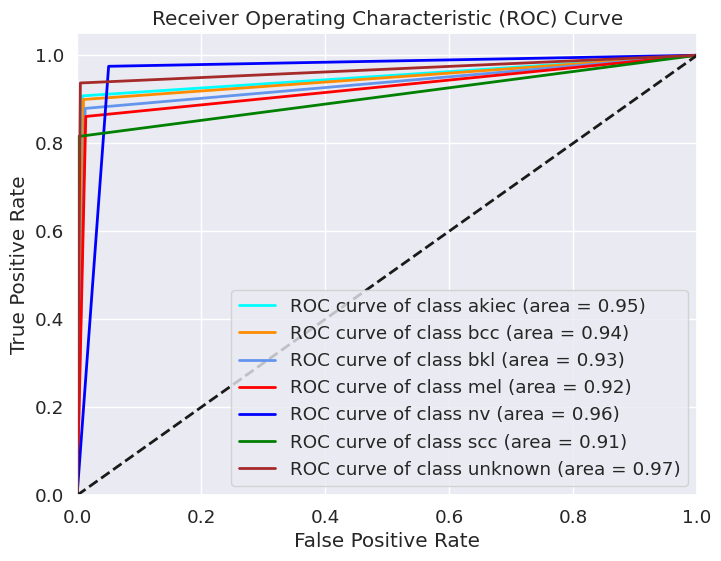

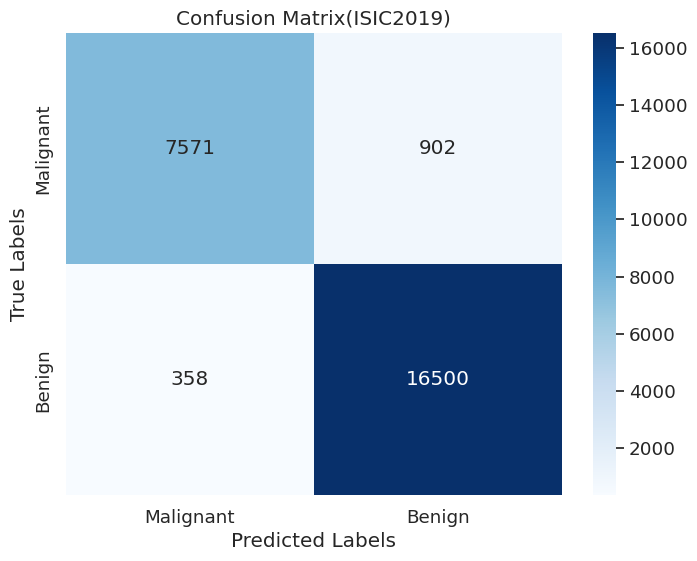


Binary Class Accuracy(ISIC2019): 0.9502585764478307
ISIC2019 Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.954849  0.893544  0.923180   8473.000000
Benign         0.948167  0.978764  0.963222  16858.000000
accuracy       0.950259  0.950259  0.950259      0.950259
macro avg      0.951508  0.936154  0.943201  25331.000000
weighted avg   0.950402  0.950259  0.949829  25331.000000

Binary Class ROC AUC Score(ISIC2019): 0.9361539954463325


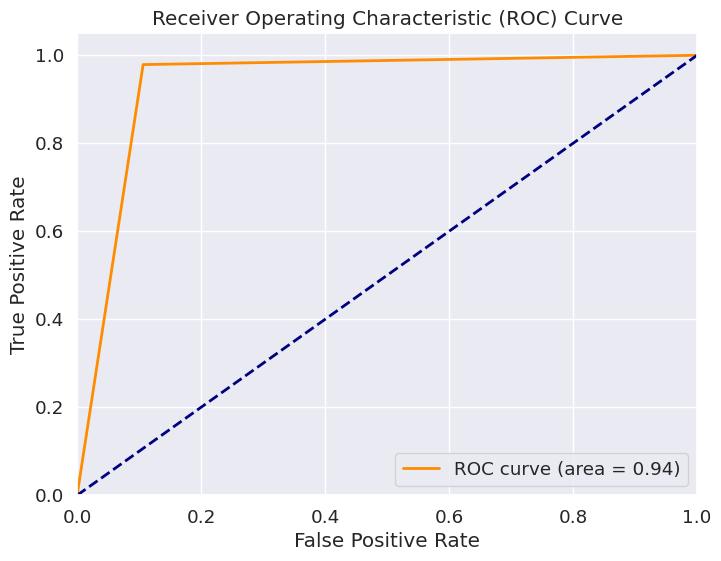

In [23]:
test_dir = '/kaggle/input/test-model-dataset/testing_model/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

2140/2140 ━━━━━━━━━━━━━━━━━━━━ 60s 28ms/step


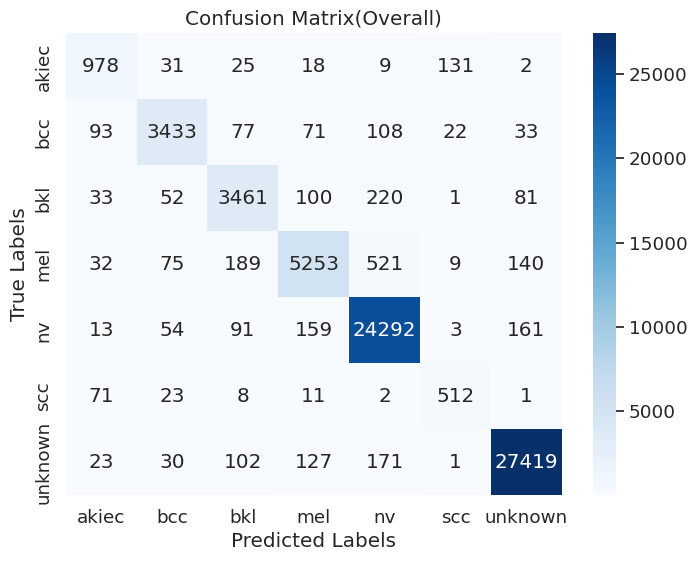


Multiclass Accuracy(Overall): 0.9543755111578456
Overall Multiclass Classification Report():
              precision    recall  f1-score       support
akiec          0.786806  0.819095  0.802626   1194.000000
bcc            0.928340  0.894709  0.911214   3837.000000
bkl            0.875538  0.876646  0.876092   3948.000000
mel            0.915316  0.844670  0.878575   6219.000000
nv             0.959286  0.980584  0.969818  24773.000000
scc            0.754050  0.815287  0.783474    628.000000
unknown        0.984984  0.983712  0.984348  27873.000000
accuracy       0.954376  0.954376  0.954376      0.954376
macro avg      0.886331  0.887815  0.886592  68472.000000
weighted avg   0.954300  0.954376  0.954133  68472.000000

Multiclass ROC AUC Score(Overall): 0.9396344067578551


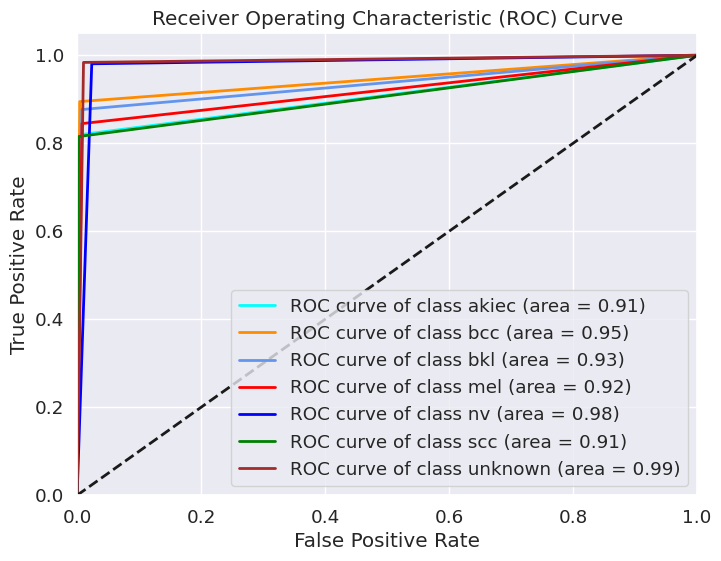

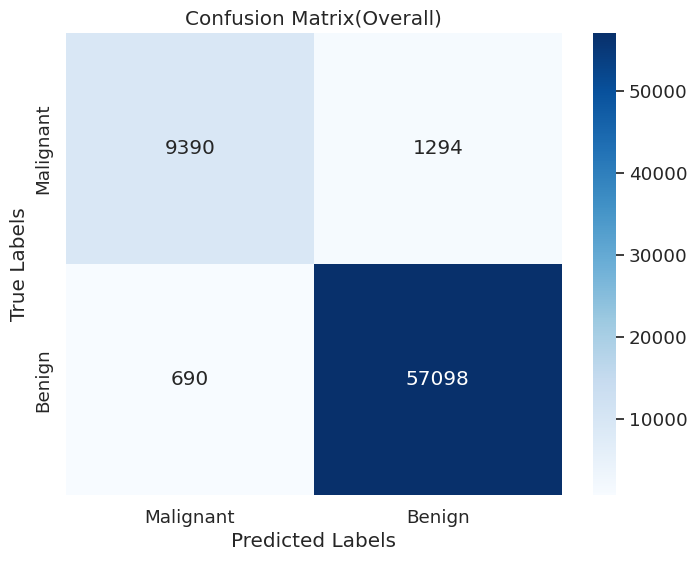


Binary Class Accuracy(Overall): 0.971024652412665
Overall Binary class Classification Report:
              precision    recall  f1-score       support
Malignant      0.931548  0.878884  0.904450  10684.000000
Benign         0.977839  0.988060  0.982923  57788.000000
accuracy       0.971025  0.971025  0.971025      0.971025
macro avg      0.954694  0.933472  0.943687  68472.000000
weighted avg   0.970616  0.971025  0.970679  68472.000000

Binary Class ROC AUC Score(Overall): 0.9334720588975773


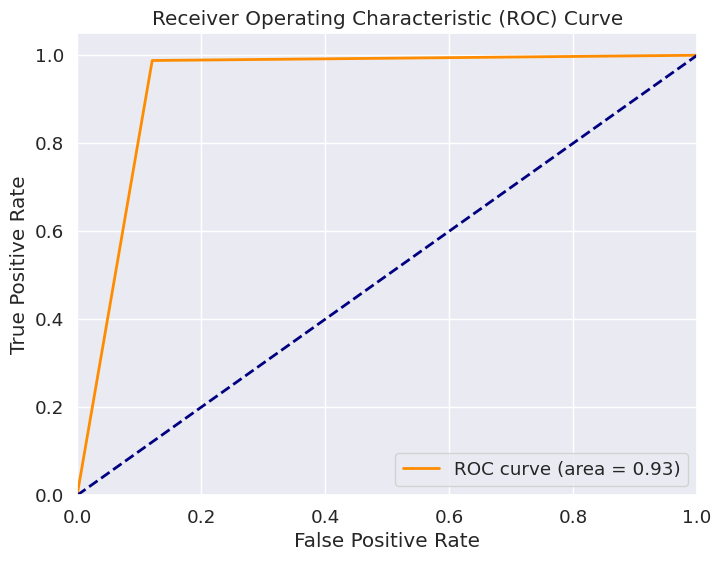

In [24]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Classification Report():")
print(report_df)

print("\nMulticlass ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         1340
mel         222
bkl         221
bcc         103
akiec        65
unknown      52
Name: count, dtype: int64
label
4    1340
3     222
2     221
1     103
0      65
6      52
Name: count, dtype: int64
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


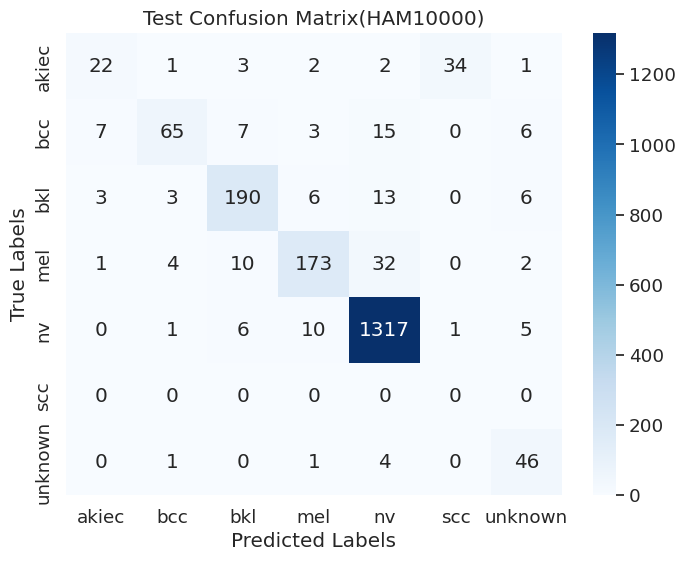


Multiclass Testing Accuracy(HAM10000): 0.9051422865701447
HAM10000 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.666667  0.338462  0.448980    65.000000
bcc            0.866667  0.631068  0.730337   103.000000
bkl            0.879630  0.859729  0.869565   221.000000
mel            0.887179  0.779279  0.829736   222.000000
nv             0.952278  0.982836  0.967315  1340.000000
scc            0.000000  0.000000  0.000000     0.000000
unknown        0.696970  0.884615  0.779661    52.000000
accuracy       0.905142  0.905142  0.905142     0.905142
macro avg      0.707056  0.639427  0.660799  2003.000000
weighted avg   0.916748  0.905142  0.907403  2003.000000

Multiclass Testing ROC AUC Score(HAM10000): 0.8606923129444674


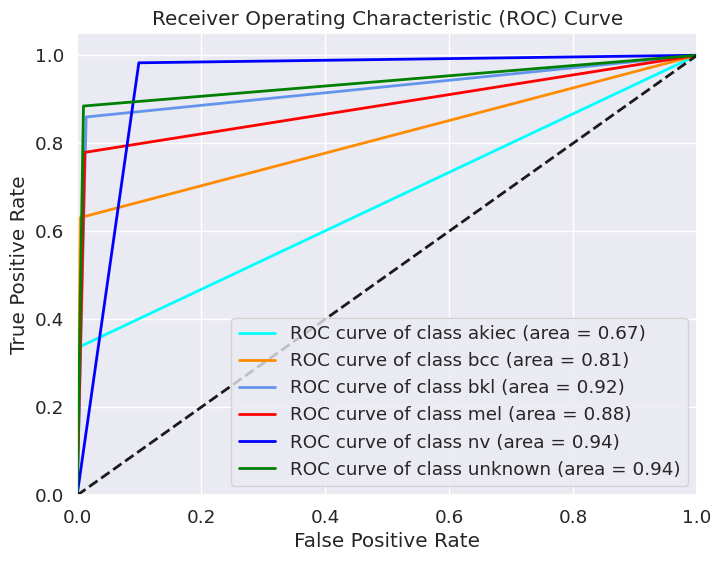

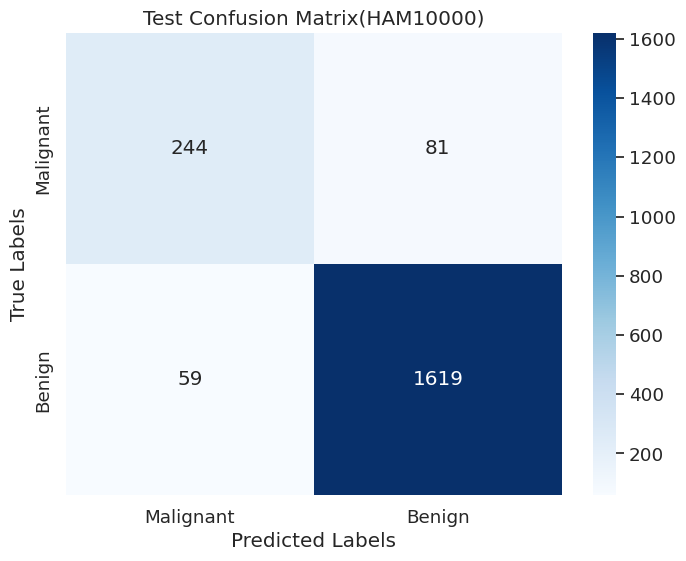


Binary Class Testing Accuracy(HAM10000): 0.9301048427358961
HAM10000 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.805281  0.750769  0.777070   325.000000
Benign         0.952353  0.964839  0.958555  1678.000000
accuracy       0.930105  0.930105  0.930105     0.930105
macro avg      0.878817  0.857804  0.867813  2003.000000
weighted avg   0.928489  0.930105  0.929108  2003.000000

Binary Class ROC AUC Score(HAM10000): 0.8578041624644723


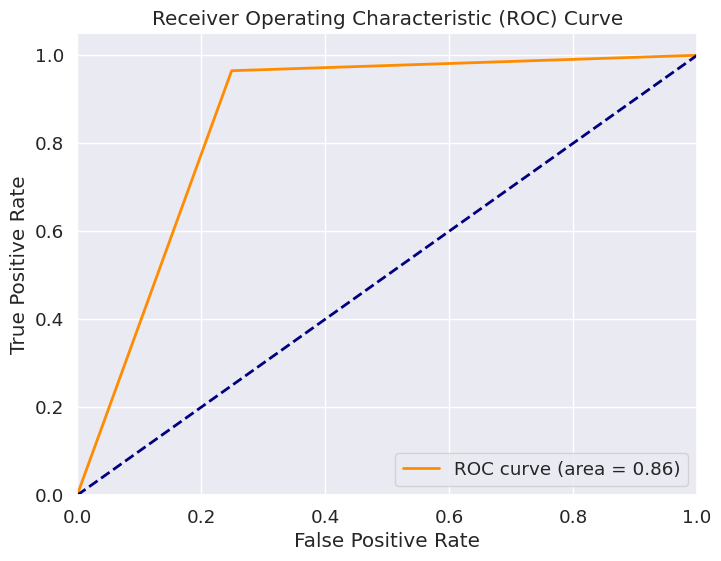

In [25]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/ham10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

x_test = np.asarray(test_df1['image'].tolist())
x_test = x_test/255.
Y=test_df1['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("HAM10000 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 6])
n_classes = 7

n_classes = y_test_bin.shape[1]  # This will now be 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(HAM10000)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(HAM10000):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("HAM10000 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(HAM10000):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
unknown    5447
nv         1030
mel         105
bkl          44
Name: count, dtype: int64
label
6    5447
4    1030
3     105
2      44
Name: count, dtype: int64
208/208 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step


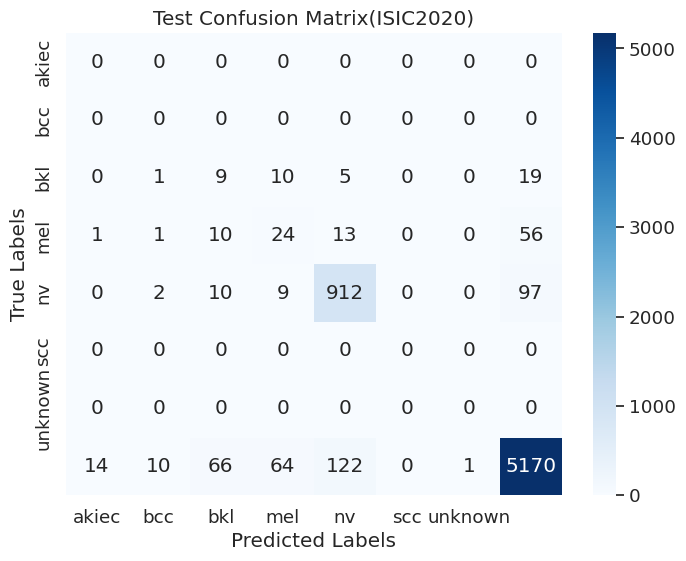


Multiclass Testing Accuracy(ISIC2020): 0.9228795653486266
ISIC2020 Multiclass Test Classification Report():
              precision    recall  f1-score     support
akiec          0.000000  0.000000  0.000000     0.00000
bcc            0.000000  0.000000  0.000000     0.00000
bkl            0.094737  0.204545  0.129496    44.00000
mel            0.224299  0.228571  0.226415   105.00000
nv             0.866920  0.885437  0.876081  1030.00000
scc            0.000000  0.000000  0.000000     0.00000
unknown        0.967802  0.949146  0.958384  5447.00000
accuracy       0.922880  0.922880  0.922880     0.92288
macro avg      0.307680  0.323957  0.312911  6626.00000
weighted avg   0.934541  0.922880  0.928486  6626.00000

Multiclass Testing ROC AUC Score(ISIC2020): 0.758875229317254


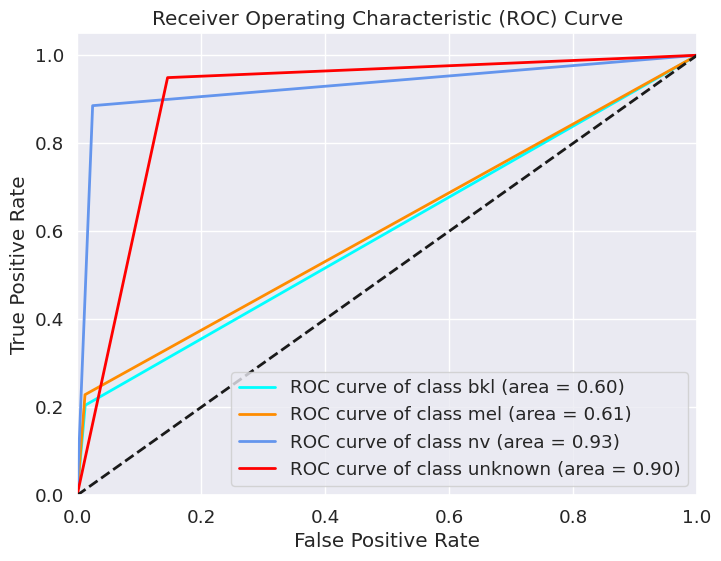

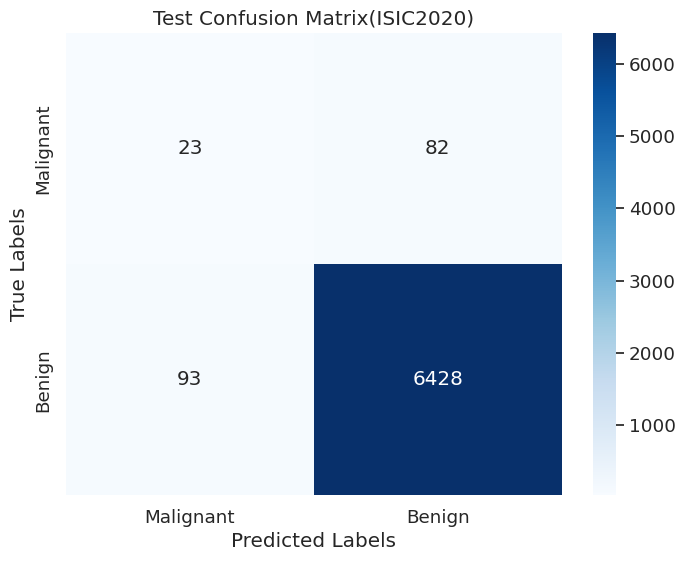


Binary Class Testing Accuracy(ISIC2020): 0.9735888922426803
ISIC2020 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.198276  0.219048  0.208145   105.000000
Benign         0.987404  0.985738  0.986570  6521.000000
accuracy       0.973589  0.973589  0.973589     0.973589
macro avg      0.592840  0.602393  0.597358  6626.000000
weighted avg   0.974899  0.973589  0.974235  6626.000000

Binary Class ROC AUC Score(ISIC2020): 0.6023930013655516


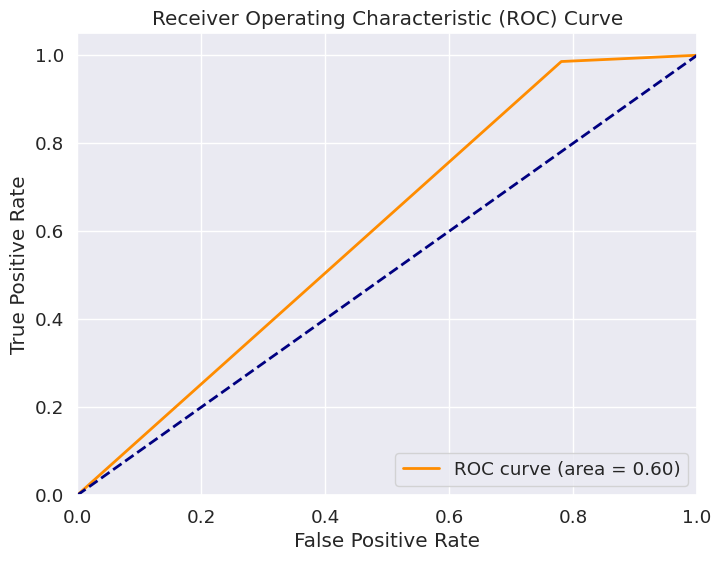

In [26]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df2['label'] = le.transform(test_df2['dx'])
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

x_test = np.asarray(test_df2['image'].tolist())
x_test = x_test/255.
Y=test_df2['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# The row you want to insert should have the same number of elements as there are columns in conf_matrix
new_row = np.zeros(conf_matrix.shape[1])

# Insert the new row at index 5
conf_matrix = np.insert(conf_matrix, 5, new_row, axis=0)
conf_matrix = np.insert(conf_matrix, 5, 0, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2020 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[2, 3, 4, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

maping = ['bkl', 'mel', 'nv', 'unknown']
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(maping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2020)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2020):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2020 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2020):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Number of pictures for each class in test folder
dx
nv         2622
mel         857
bcc         695
bkl         508
akiec       164
scc         128
unknown      93
Name: count, dtype: int64
label
4    2622
3     857
1     695
2     508
0     164
5     128
6      93
Name: count, dtype: int64
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


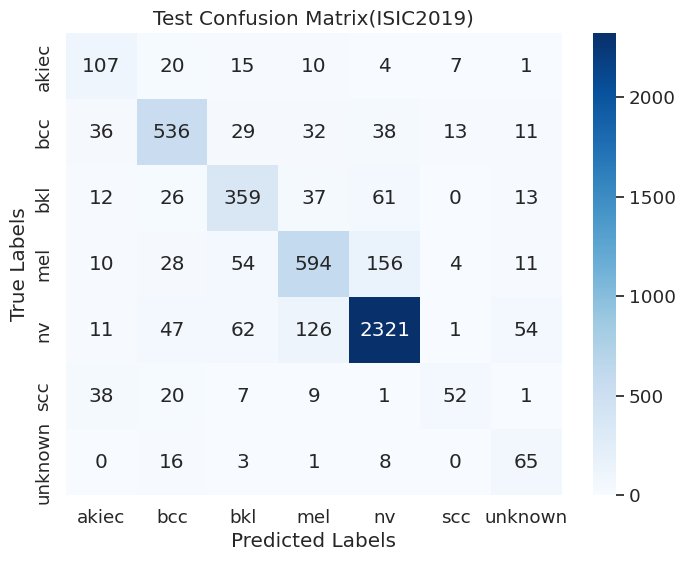


Multiclass Testing Accuracy(ISIC2019): 0.7961318334320111
ISIC2019 Multiclass Test Classification Report():
              precision    recall  f1-score      support
akiec          0.500000  0.652439  0.566138   164.000000
bcc            0.773449  0.771223  0.772334   695.000000
bkl            0.678639  0.706693  0.692382   508.000000
mel            0.734240  0.693116  0.713085   857.000000
nv             0.896485  0.885202  0.890808  2622.000000
scc            0.675325  0.406250  0.507317   128.000000
unknown        0.416667  0.698925  0.522088    93.000000
accuracy       0.796132  0.796132  0.796132     0.796132
macro avg      0.667829  0.687692  0.666307  5067.000000
weighted avg   0.803101  0.796132  0.797642  5067.000000

Multiclass Testing ROC AUC Score(ISIC2019): 0.823913395058656


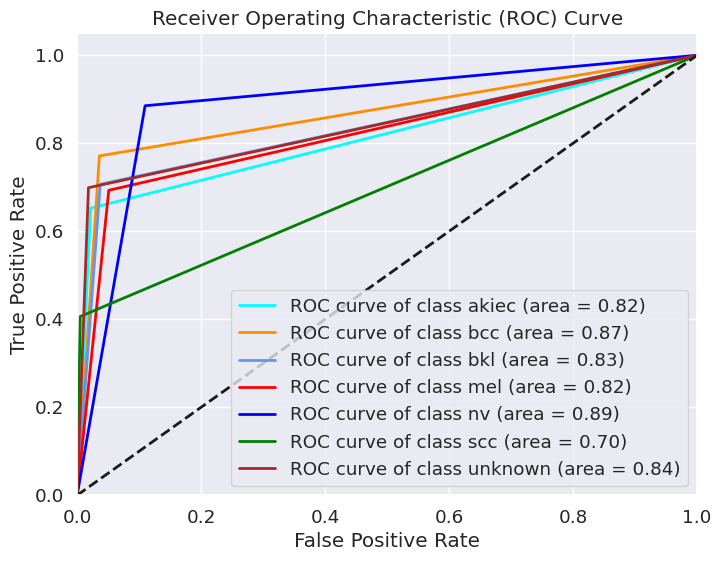

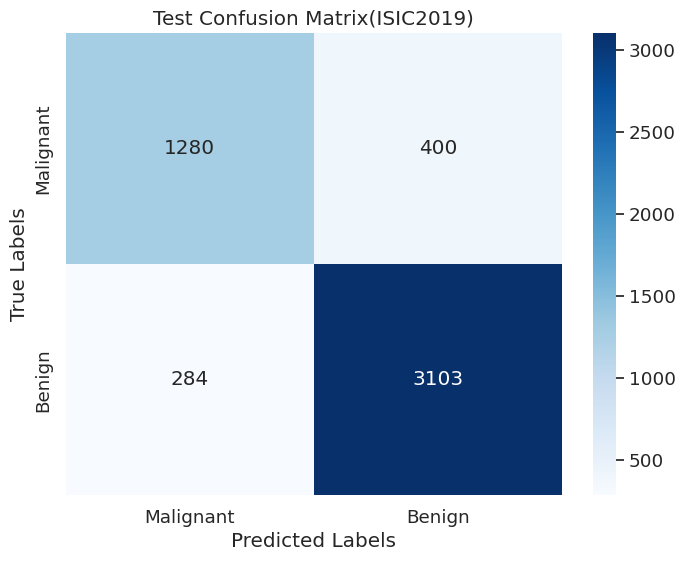


Binary Class Testing Accuracy(ISIC2019): 0.8650088809946714
ISIC2019 Binary class Testing Classification Report:
              precision    recall  f1-score      support
Malignant      0.818414  0.761905  0.789149  1680.000000
Benign         0.885812  0.916150  0.900726  3387.000000
accuracy       0.865009  0.865009  0.865009     0.865009
macro avg      0.852113  0.839027  0.844937  5067.000000
weighted avg   0.863466  0.865009  0.863732  5067.000000

Binary Class ROC AUC Score(ISIC2019): 0.8390273735712177


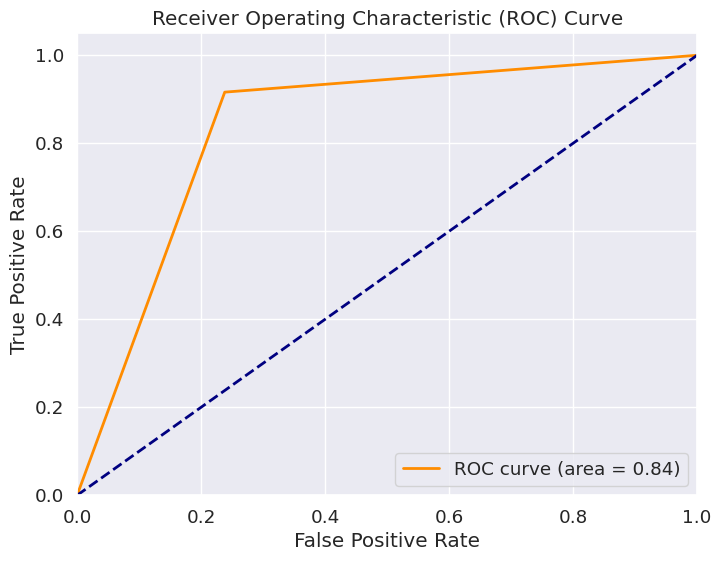

In [27]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)

del test_metadata

# Now you can transform the labels in your dataframe
test_df3['label'] = le.transform(test_df3['dx'])
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

x_test = np.asarray(test_df3['image'].tolist())
x_test = x_test/255.
Y=test_df3['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("ISIC2019 Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(ISIC2019)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(ISIC2019):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("ISIC2019 Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(ISIC2019):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

428/428 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step


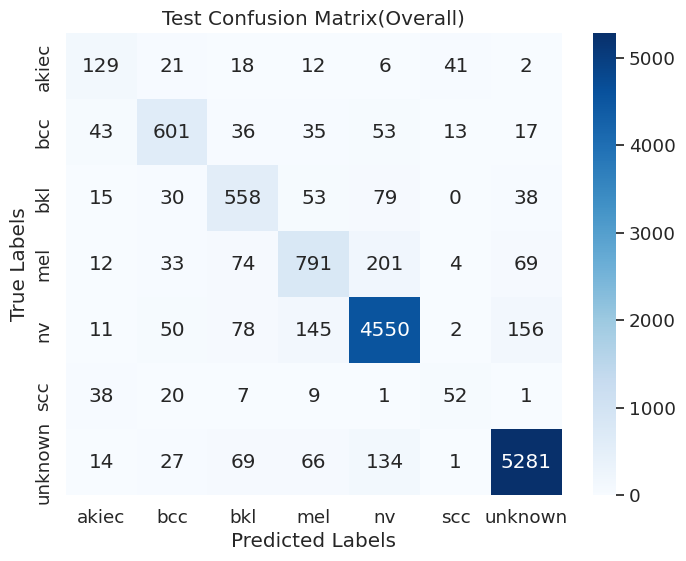


Multiclass Testing Accuracy(Overall): 0.873393691588785
Overall Multiclass Test Classification Report():
              precision    recall  f1-score       support
akiec          0.492366  0.563319  0.525458    229.000000
bcc            0.768542  0.753133  0.760759    798.000000
bkl            0.664286  0.721863  0.691878    773.000000
mel            0.711971  0.668074  0.689325   1184.000000
nv             0.905653  0.911458  0.908546   4992.000000
scc            0.460177  0.406250  0.431535    128.000000
unknown        0.949137  0.944385  0.946755   5592.000000
accuracy       0.873394  0.873394  0.873394      0.873394
macro avg      0.707448  0.709783  0.707751  13696.000000
weighted avg   0.873979  0.873394  0.873492  13696.000000

Multiclass Testing ROC AUC Score(Overall): 0.8430929408510163


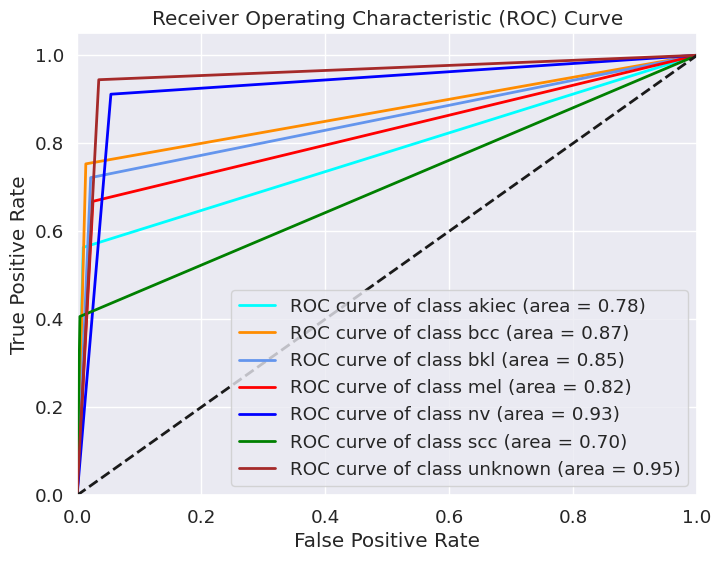

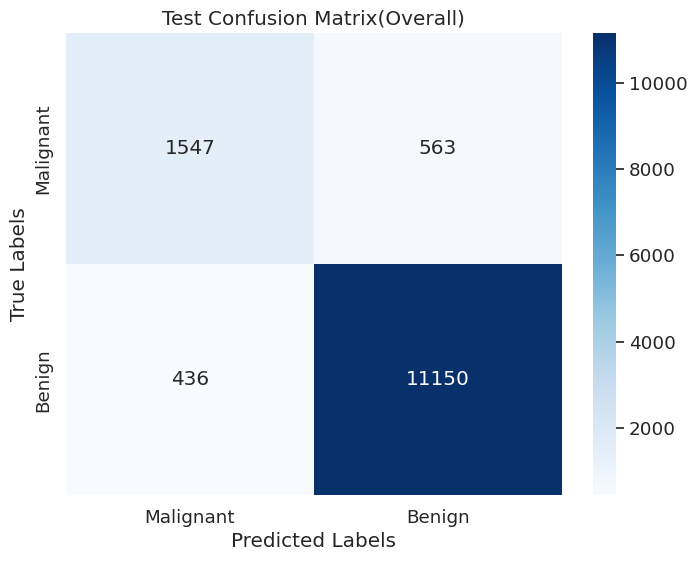


Binary Class Testing Accuracy(Overall): 0.9270589953271028
Overall Binary class Testing Classification Report:
              precision    recall  f1-score       support
Malignant      0.780131  0.733175  0.755925   2110.000000
Benign         0.951934  0.962368  0.957123  11586.000000
accuracy       0.927059  0.927059  0.927059      0.927059
macro avg      0.866032  0.847772  0.856524  13696.000000
weighted avg   0.925466  0.927059  0.926126  13696.000000

Binary Class ROC AUC Score(Overall): 0.847771865537996


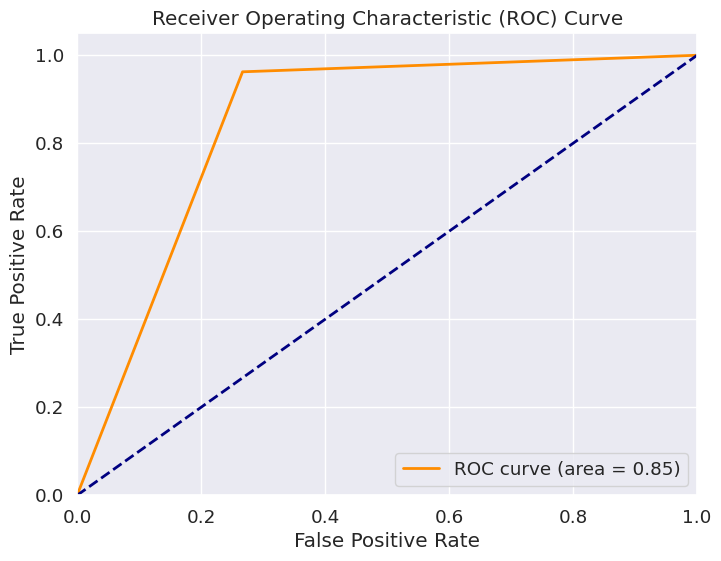

In [28]:
test_df = pd.concat([test_df1, test_df2, test_df3])
x_test = np.asarray(test_df['image'].tolist())
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)
# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nMulticlass Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

lb = LabelBinarizer()

lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Overall Multiclass Test Classification Report():")
print(report_df)

print("\nMulticlass Testing ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_true_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1] 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # This will iterate over indices 0-5
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves

plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'brown'])
for i, color in zip([0, 1, 2, 3, 4, 5, 6], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_to_dx_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix(Overall)')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nBinary Class Testing Accuracy(Overall):", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Overall Binary class Testing Classification Report:")
print(report_df)

print("\nBinary Class ROC AUC Score(Overall):", roc_auc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()